## 4. Evaluation

### 4.1 Importing the Library

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow sedang berjalan di mode: CPU ONLY")

2026-01-18 14:51:58.153456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-18 14:51:58.254453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-18 14:52:01.137715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU Available:  []
TensorFlow sedang berjalan di mode: CPU ONLY


2026-01-18 14:52:03.319015: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-18 14:52:03.319113: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-18 14:52:03.319124: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-18 14:52:03.319132: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-18 14:52:03.319141: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: msi
2026-01-18 14:52:03.319145: I external/local_xla/xla/stream_executor/cuda/cuda_diag

In [2]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

In [3]:
DATA_DIR = "../dataset/processed/02_after_FE_raw"
MODEL_DIR = "../models"

### 4.2 Load the Data

In [4]:
X_test_tfidf  = pickle.load(open(os.path.join(DATA_DIR, "X_test_tfidf.pkl"), "rb"))
X_test_pad    = pickle.load(open(os.path.join(DATA_DIR, "X_test_pad.pkl"), "rb"))
y_test        = pickle.load(open(os.path.join(DATA_DIR, "y_test.pkl"), "rb"))

y_test = np.array(y_test)

### 4.3 Check Array Dimension

In [5]:
# Data Type Conversion
X_test_pad   = np.array(X_test_pad, dtype='int32')     # Sequence
X_test_tfidf = np.array(X_test_tfidf, dtype='float32') # TFIDF
y_test       = np.array(y_test, dtype='float32')       # Label

# For Scikit-learn (Random Forest)
y_test_sklearn = y_test.astype(int).ravel()

print("Data types converted successfully.")

Data types converted successfully.


### 4.4 Load Models

In [6]:
rf_model     = pickle.load(open(os.path.join(MODEL_DIR, "rf_model_raw.pkl"), "rb"))
lstm_model   = load_model(os.path.join(MODEL_DIR, "lstm_model_raw.keras"))
bilstm_model = load_model(os.path.join(MODEL_DIR, "bilstm_model_raw.keras"))

### 4.5 Evaluating Function

In [7]:
def evaluate_model_metrics(y_true, y_pred_binary, y_pred_proba):
    """Menghitung metrik evaluasi utama."""
    
    acc = accuracy_score(y_true, y_pred_binary)
    prec = precision_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    rec = recall_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0, pos_label=1)
    
    return {
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
    }

def round_metrics(metrics_dict):
    return {k: round(v, 4) for k, v in metrics_dict.items()}

### 4.6 Predicting and Evaluate All Models

In [8]:
scores = {}

# Random Forest
rf_pred_proba = rf_model.predict_proba(X_test_tfidf)[:, 1] 
rf_pred_binary = rf_model.predict(X_test_tfidf) 
scores['Random Forest + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, rf_pred_binary, rf_pred_proba)
)

#LSTM
lstm_pred_proba = lstm_model.predict([X_test_pad, X_test_tfidf], verbose=0).flatten() 
lstm_pred_binary = (lstm_pred_proba > 0.5).astype(int)
scores['LSTM + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, lstm_pred_binary, lstm_pred_proba)
)

# BiLSTM
bilstm_pred_proba = bilstm_model.predict([X_test_pad, X_test_tfidf], verbose=0).flatten()
bilstm_pred_binary = (bilstm_pred_proba > 0.5).astype(int)
scores['BiLSTM + TF-IDF'] = round_metrics(
    evaluate_model_metrics(y_test_sklearn, bilstm_pred_binary, bilstm_pred_proba)
)


for model_name, metrics in scores.items():
    print(f"\n-{model_name}-")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.1s finished



-Random Forest + TF-IDF-
accuracy: 0.978
precision: 0.8305
recall: 0.9018
f1: 0.8647

-LSTM + TF-IDF-
accuracy: 0.9856
precision: 0.9182
recall: 0.8957
f1: 0.9068

-BiLSTM + TF-IDF-
accuracy: 0.9622
precision: 0.7143
recall: 0.8589
f1: 0.7799


In [9]:
results_df = pd.DataFrame(scores).T 

results_df = results_df.rename_axis('Model')
results_df = results_df.reset_index() 

print("--- Comparison ---")
print(results_df.to_markdown(index=False, numalign="left", stralign="left"))

--- Comparison ---
| Model                  | accuracy   | precision   | recall   | f1     |
|:-----------------------|:-----------|:------------|:---------|:-------|
| Random Forest + TF-IDF | 0.978      | 0.8305      | 0.9018   | 0.8647 |
| LSTM + TF-IDF          | 0.9856     | 0.9182      | 0.8957   | 0.9068 |
| BiLSTM + TF-IDF        | 0.9622     | 0.7143      | 0.8589   | 0.7799 |


### 4.7 Visualizing

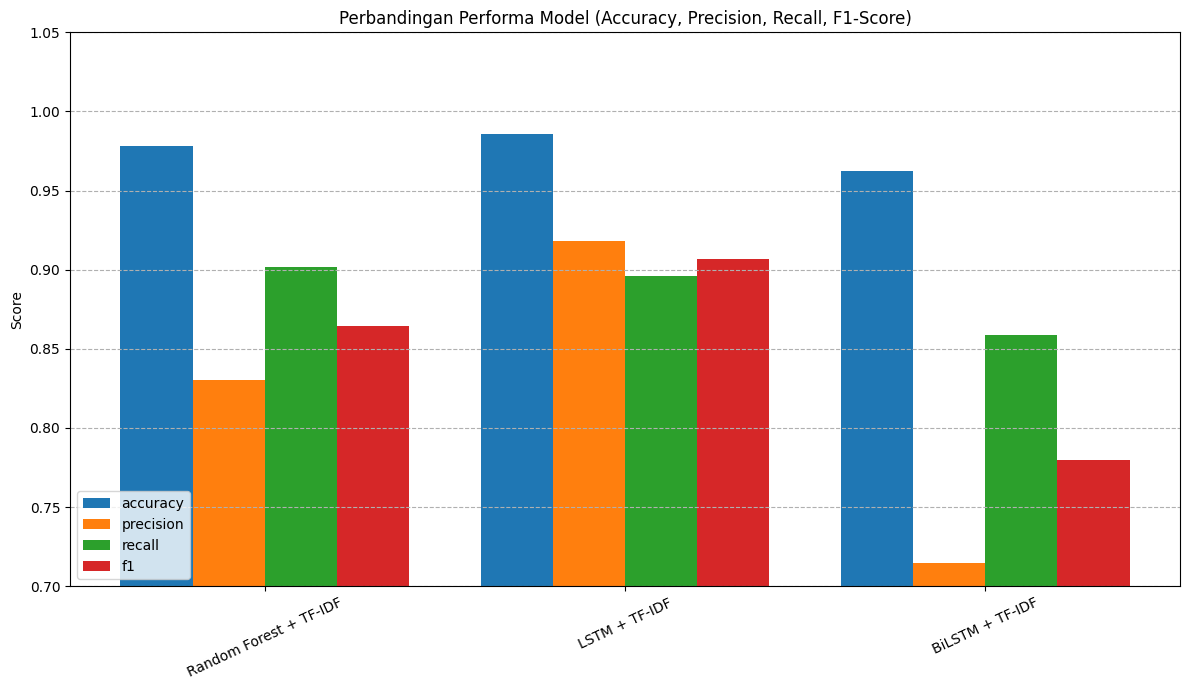

In [10]:
models = list(scores.keys())
metrics = ["accuracy", "precision", "recall", "f1"]

values = np.array([[scores[m][metric] for metric in metrics] for m in models])

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12, 7)) 

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, values[:, i], width, label=metric)

plt.xticks(x + width * 1.5, models, rotation=25) 
plt.ylabel("Score")
plt.ylim(0.70, 1.05)
plt.title("Perbandingan Performa Model (Accuracy, Precision, Recall, F1-Score)")
plt.legend(loc='lower left')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
